# IMPORTACIONES BÁSICAS

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# DATASET PARA ALGORITMOS SUPERVISADOS

## CARGA DEL FICHERO

In [36]:
df = pd.read_csv('direct_marketing.csv')
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,DM_category
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,4
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,11
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,2
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,4


In [37]:
df.conversion.value_counts()

conversion
0    63422
1      578
Name: count, dtype: int64

## BALANCEO DE CLASES

In [38]:
from sklearn.utils import resample

df_majority = df[df['conversion'] == 0]
df_minority = df[df['conversion'] == 1]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

## PREDICTORAS Y TARGET

In [39]:
X = df_balanced[['recency',
 'history_segment',
 'history',
 'mens',
 'womens',
 'zip_code',
 'newbie',
 'channel',
 'segment',
 'DM_category']]
       
y = df_balanced.conversion       

## PREPARACIÓN DE DATOS

In [40]:
from sklearn.preprocessing import OneHotEncoder

object_columns = X.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, drop='first')

X_encoded = pd.DataFrame(encoder.fit_transform(X[object_columns]))
X_encoded.columns = encoder.get_feature_names_out(object_columns)

X = X.drop(object_columns, axis=1).reset_index()


In [41]:
X = pd.concat([X, X_encoded], axis=1)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = X.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns)


## SEPARACIÓN DE TRAIN Y TEST

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## FUNCIÓN PARA MEDIR EL ERROR

In [44]:
from sklearn.metrics import roc_auc_score

def mide_error(nombre_modelo, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC de {nombre_modelo}: ', round(auc,2))

# DATASET PARA SERIES TEMPORALES

## CARGA DEL FICHERO

In [45]:
import statsmodels.api as sm

df_st = sm.datasets.macrodata.load_pandas().data.loc[:,['year','quarter','infl']]
df_st['period'] = pd.PeriodIndex(year=df_st['year'], quarter=df_st['quarter'], freq='Q')
df_st.set_index('period', inplace=True)
df_st.drop(['year', 'quarter'], axis=1, inplace=True)
df_st.head()

,infl
period,
1959Q1,0.00
1959Q2,2.34
1959Q3,2.74
1959Q4,0.27
1960Q1,2.31


## SEPARACIÓN DE TRAIN Y TEST

In [46]:
train_data = df_st.iloc[:-4]
test_data = df_st.iloc[-4:] 
train_data = train_data['infl'].values.astype(np.float64)

# REGRESIÓN LOGÍSTICA

In [47]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='newton-cg')
logreg.fit(X_train, y_train)

y_pred = logreg.predict_proba(X_test)[:,1]

mide_error('Regresión Logística', y_pred)

AUC de Regresión Logística:  0.6


# KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict_proba(X_test)[:,1]

mide_error('KNN', y_pred)

AUC de KNN:  0.57


# NAIVE BAYES

In [49]:
from sklearn.naive_bayes import BernoulliNB

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict_proba(X_test)[:,1]

mide_error('Naive Bayes', y_pred)

AUC de Naive Bayes:  0.58


# K-MEDIAS

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

kmeans.fit(X_train)

kmeans.labels_[:10]

/home/jvmx/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([4, 2, 3, 0, 0, 2, 0, 2, 0, 1], dtype=int32)

# ÁRBOL DE DECISIÓN

In [51]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict_proba(X_test)[:,1]

mide_error('Árbol de Decisión', y_pred)

AUC de Árbol de Decisión:  0.57


# ARIMA

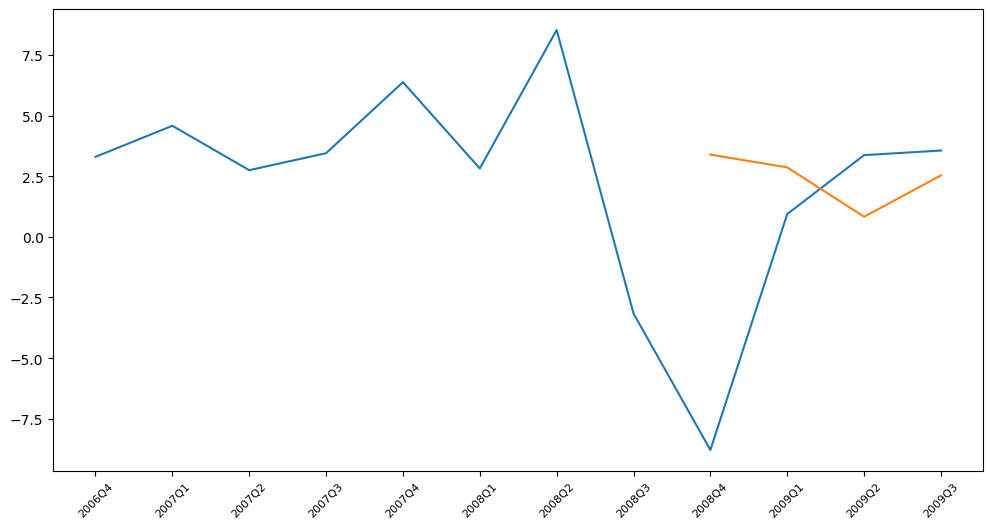

In [52]:
from pmdarima import auto_arima


model = auto_arima(train_data, seasonal=False, suppress_warnings=True)
model_fit = model.fit(train_data)
predictions = model_fit.predict(n_periods=len(test_data))


plt.figure(figsize=(12, 6))
plt.plot(df_st[-12:].index.strftime('%YQ%q'), df_st[-12:].infl, label='Realidad')
plt.plot(df_st[-4:].index.strftime('%YQ%q'), predictions, label='Predicción')
plt.xticks(rotation=45, fontsize=8);

# SUAVIZADO EXPONENCIAL

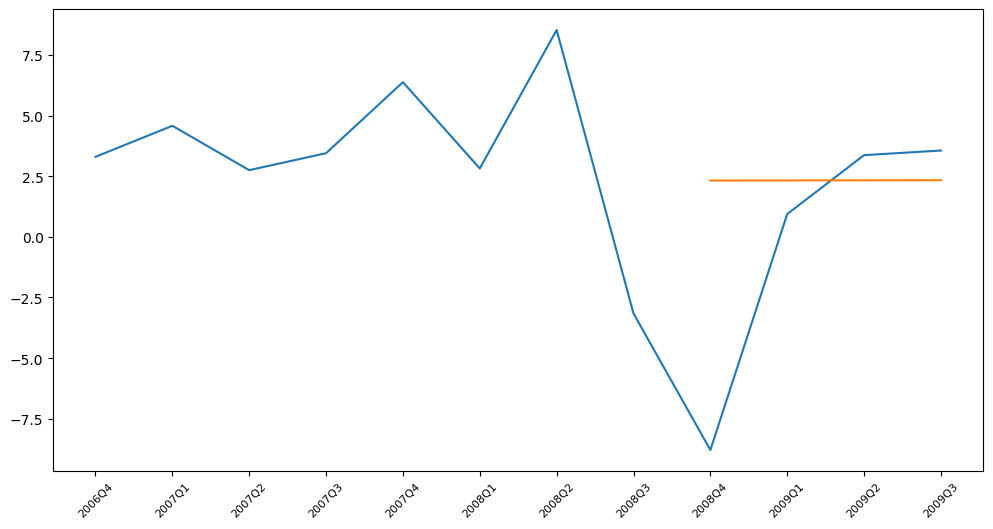

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train_data, seasonal=None, trend='add')
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

plt.figure(figsize=(12, 6))
plt.plot(df_st[-12:].index.strftime('%YQ%q'), df_st[-12:].infl, label='Realidad')
plt.plot(df_st[-4:].index.strftime('%YQ%q'), predictions, label='Predicción')
plt.xticks(rotation=45, fontsize=8);

# RANDOM FOREST

In [54]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict_proba(X_test)[:,1]

mide_error('Random Forest', y_pred)


AUC de Random Forest:  0.58


# XGBBOOST

In [55]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict_proba(X_test)[:,1]

mide_error('XGBboost', y_pred)

AUC de XGBboost:  0.53


# LIGHTGBM

In [56]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boosting = HistGradientBoostingClassifier()
hist_gradient_boosting.fit(X_train, y_train)

y_pred = hist_gradient_boosting.predict_proba(X_test)[:,1]

mide_error('XGBboost', y_pred)

AUC de XGBboost:  0.54
